# Football Match Prediction

In [13]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

## 1. Data Loading

In [14]:
from pathlib import Path
import pandas as pd
import os

# Set the base data path
DATA_PATH = Path('data')

def load_data(data_dir: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    base_path = DATA_PATH / data_dir
    
    # Determine the prefix based on the data_dir
    prefix = 'train' if 'Train' in data_dir else 'test'
    
    # Define the expected filenames
    filenames = {
        'home_player': f'{prefix}_home_player_statistics_df.csv',
        'home_team': f'{prefix}_home_team_statistics_df.csv',
        'away_player': f'{prefix}_away_player_statistics_df.csv',
        'away_team': f'{prefix}_away_team_statistics_df.csv'
    }
    
    # Initialize a dictionary to hold DataFrames
    dataframes = {}
    
    # Load each CSV file
    for key, filename in filenames.items():
        file_path = base_path / filename
        if not file_path.exists():
            raise FileNotFoundError(f"Expected file {filename} not found in {base_path}.")
        
        dataframes[key] = pd.read_csv(file_path)
    
    return (
        dataframes['home_player'],
        dataframes['home_team'],
        dataframes['away_player'],
        dataframes['away_team']
    )


try:
    # Load training data
    print("\nLoading Training Data:")
    train_home_player, train_home_team, train_away_player, train_away_team = load_data('Train_Data')
    
    # Load target variables
    y_train_path = DATA_PATH / 'Y_train_1rknArQ.csv'
    y_train_supp_path = DATA_PATH / 'benchmark_and_extras' / 'Y_train_supp.csv'
    
    print(f"\nLoading target variable {y_train_path.name}...")
    y_train = pd.read_csv(y_train_path)
    
    print(f"Loading supplementary target variable {y_train_supp_path.name}...")
    y_train_supp = pd.read_csv(y_train_supp_path)
    
    print("\nAll data loaded successfully.")

except FileNotFoundError as e:
    print(f"\nFile Not Found Error: {e}")
except pd.errors.EmptyDataError as e:
    print(f"\nEmpty Data Error: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

def display_sample_data():
    print("\nSample Data from Training Sets:")
    print("\nHome Player Statistics:")
    print(train_home_player.head())
    
    print("\nHome Team Statistics:")
    print(train_home_team.head())
    
    print("\nAway Player Statistics:")
    print(train_away_player.head())
    
    print("\nAway Team Statistics:")
    print(train_away_team.head())
    
    print("\nY_train:")
    print(y_train.head())
    
    print("\nY_train_supp:")
    print(y_train_supp.head())

display_sample_data()



Loading Training Data:

Loading target variable Y_train_1rknArQ.csv...
Loading supplementary target variable Y_train_supp.csv...

All data loaded successfully.

Sample Data from Training Sets:

Home Player Statistics:
   ID   LEAGUE TEAM_NAME    POSITION          PLAYER_NAME  \
0   0  Ligue 1  Toulouse    defender        Agustín Rogel   
1   0  Ligue 1  Toulouse    defender    Mathieu Goncalves   
2   0  Ligue 1  Toulouse  goalkeeper      Baptiste Reynet   
3   0  Ligue 1  Toulouse  midfielder  Jean-Victor Makengo   
4   0  Ligue 1  Toulouse         NaN  Efthymios Koulouris   

   PLAYER_ACCURATE_CROSSES_season_sum  PLAYER_ACCURATE_PASSES_season_sum  \
0                                 0.0                                8.0   
1                                 0.0                                7.0   
2                                 0.0                               33.0   
3                                 8.0                               27.0   
4                                 

Running Exploratory Data Analysis...

Dataset Shapes:
Home Player: (237079, 307)
Missing values: 14094447

Home Team: (12303, 143)
Missing values: 82407

Away Player: (236132, 307)
Missing values: 14120485

Away Team: (12303, 143)
Missing values: 82495



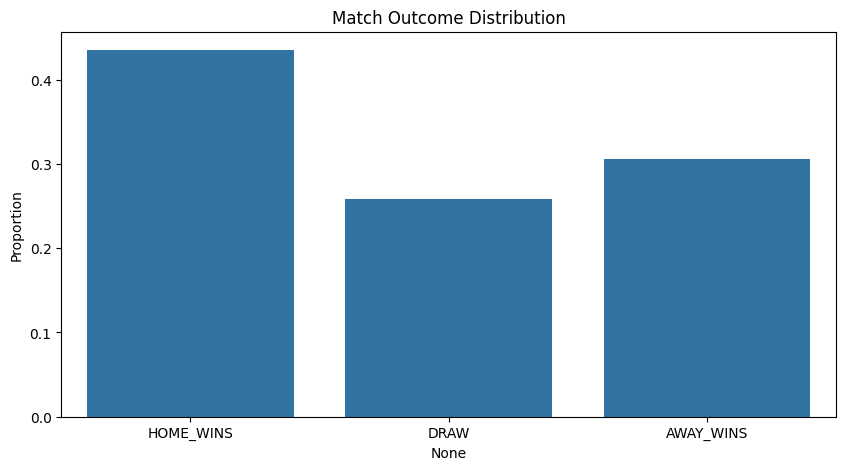


Outcome Distribution:
HOME_WINS: 43.5%
DRAW: 25.9%
AWAY_WINS: 30.6%


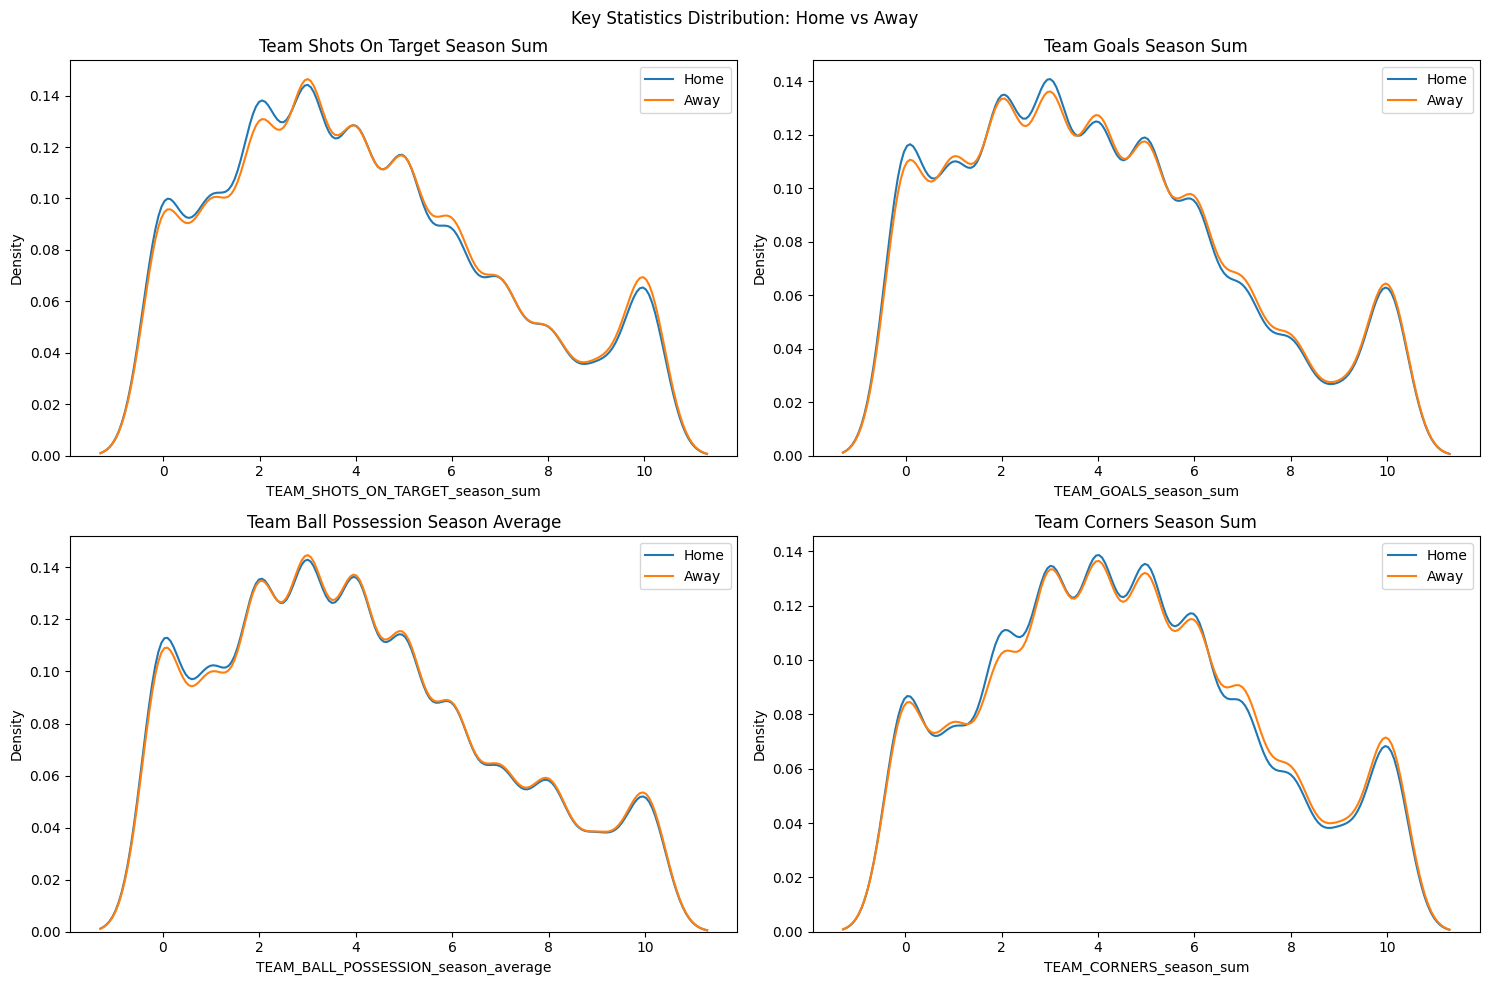

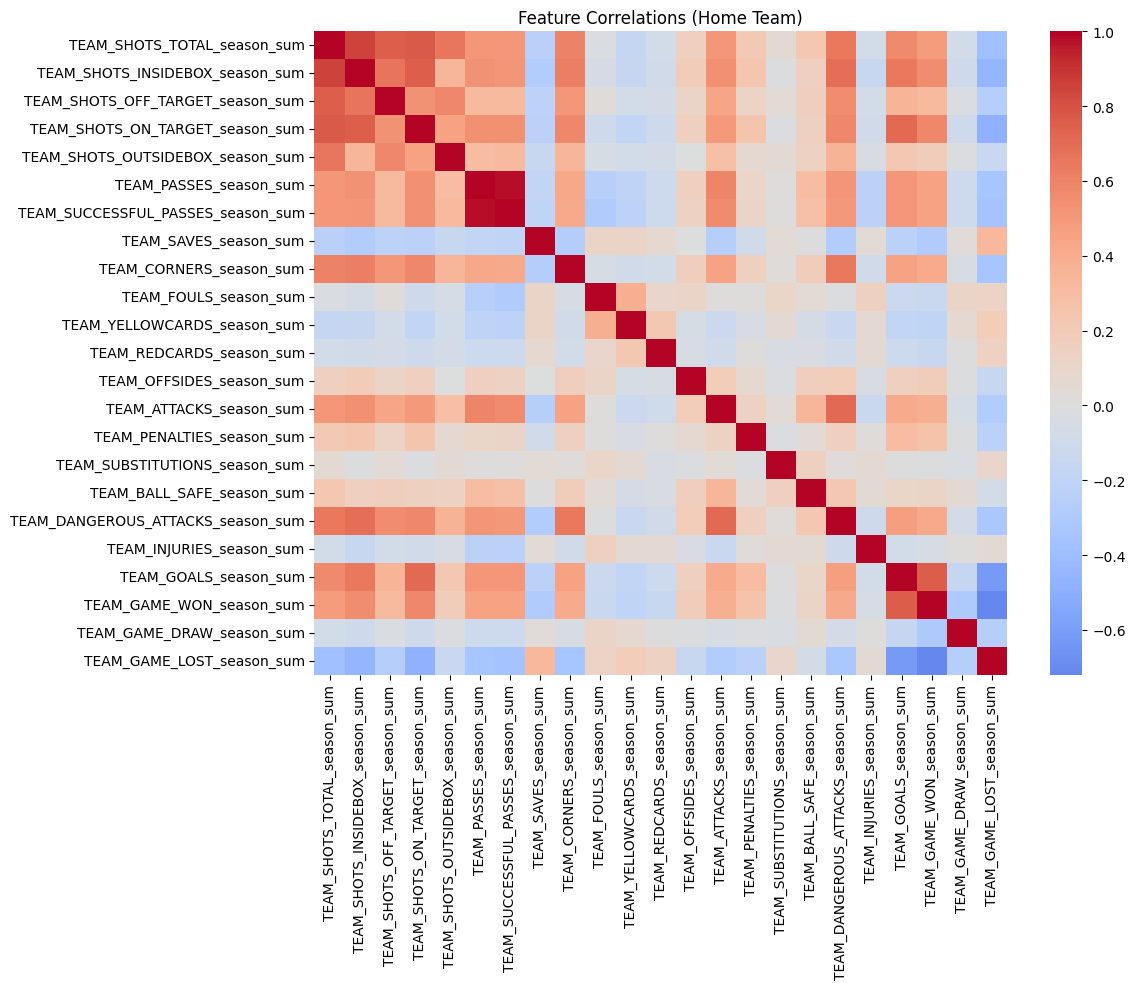

In [ ]:
# Data Shape and Info
def analyze_dataset_structure():
    datasets = {
        'Home Player': train_home_player,
        'Home Team': train_home_team,
        'Away Player': train_away_player,
        'Away Team': train_away_team,
    }
    
    print("Dataset Shapes:")
    for name, df in datasets.items():
        print(f"{name}: {df.shape}")
        print(f"Missing values: {df.isna().sum().sum()}\n")

# Target Distribution Analysis
def analyze_target_distribution():
    target_dist = y_train[['HOME_WINS', 'DRAW', 'AWAY_WINS']].sum()
    total_matches = len(y_train)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=target_dist.index, y=target_dist.values / total_matches)
    plt.title('Match Outcome Distribution')
    plt.ylabel('Proportion')
    plt.show()
    
    print("\nOutcome Distribution:")
    for col in ['HOME_WINS', 'DRAW', 'AWAY_WINS']:
        pct = (y_train[col].sum() / total_matches) * 100
        print(f"{col}: {pct:.1f}%")

# Key Statistics Analysis
def analyze_key_stats():
    stats_to_analyze = [
        'TEAM_SHOTS_ON_TARGET_season_sum',
        'TEAM_GOALS_season_sum',
        'TEAM_BALL_POSSESSION_season_average',
        'TEAM_CORNERS_season_sum'
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Key Statistics Distribution: Home vs Away')
    
    for idx, stat in enumerate(stats_to_analyze):
        ax = axes[idx // 2, idx % 2]
        sns.kdeplot(data=train_home_team[stat], ax=ax, label='Home')
        sns.kdeplot(data=train_away_team[stat], ax=ax, label='Away')
        ax.set_title(stat.replace('_', ' ').title())
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Feature Correlation Analysis
def analyze_correlations():
    selected_features = [col for col in train_home_team.columns 
                        if col.endswith('_season_sum') and 'TEAM_' in col]
    
    correlation_matrix = train_home_team[selected_features].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlations (Home Team)')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Run analyses
import seaborn as sns
import matplotlib.pyplot as plt

print("Running Exploratory Data Analysis...\n")
analyze_dataset_structure()
analyze_target_distribution()
analyze_key_stats()
analyze_correlations()

Running Player Statistics EDA...

Player Dataset Shapes and Missing Values:

Home Player: (237079, 307)
Missing values: 14094447

Away Player: (236132, 307)
Missing values: 14120485

Missing Values in Player Datasets:

Home Player Missing Values:
POSITION                                     42820
PLAYER_ACCURATE_CROSSES_season_sum           28289
PLAYER_ACCURATE_PASSES_season_sum            28289
PLAYER_AERIALS_WON_season_sum                28289
PLAYER_ASSISTS_season_sum                     3597
                                             ...  
PLAYER_YELLOWCARDS_5_last_match_std           7443
PLAYER_PUNCHES_5_last_match_std             170579
PLAYER_LONG_BALLS_5_last_match_std          237079
PLAYER_LONG_BALLS_WON_5_last_match_std      237079
PLAYER_SHOTS_OFF_TARGET_5_last_match_std    237079
Length: 303, dtype: int64


Away Player Missing Values:
POSITION                                     42255
PLAYER_ACCURATE_CROSSES_season_sum           28470
PLAYER_ACCURATE_PASSES_season_sum 

,ID,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,PLAYER_BIG_CHANCES_MISSED_season_sum,PLAYER_BLOCKED_SHOTS_season_sum,PLAYER_CAPTAIN_season_sum,PLAYER_CLEARANCES_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
count,237079.000000,208790.000000,208790.000000,208790.000000,233482.000000,207184.000000,207184.000000,207184.000000,25290.000000,208790.000000,...,229636.000000,180164.000000,205393.000000,205393.000000,205393.000000,229636.000000,66500.000000,0.0,0.0,0.0
mean,6151.422454,7.926907,22.719675,12.719670,9.301141,9.298498,7.219274,10.449895,34.374575,13.541597,...,32.848983,14.633650,21.673538,12.412098,27.139586,25.537786,2.118481,NaN,NaN,NaN
std,3552.223779,15.098380,20.848741,16.201509,16.382073,15.763732,14.599223,16.975008,35.103040,18.505913,...,36.464190,17.543558,19.338093,16.668662,19.414030,33.779798,11.188666,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,3080.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,NaN,NaN,NaN
50%,6152.000000,1.000000,18.000000,7.000000,0.000000,0.000000,0.000000,3.000000,20.000000,6.000000,...,0.000000,12.000000,19.000000,7.000000,26.000000,0.000000,0.000000,NaN,NaN,NaN
75%,9227.000000,9.000000,34.000000,18.000000,14.000000,14.000000,9.000000,14.000000,66.000000,18.000000,...,70.000000,23.000000,33.000000,19.000000,39.000000,63.000000,0.000000,NaN,NaN,NaN
max,12302.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN




Away Player Summary Statistics:


,ID,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,PLAYER_BIG_CHANCES_MISSED_season_sum,PLAYER_BLOCKED_SHOTS_season_sum,PLAYER_CAPTAIN_season_sum,PLAYER_CLEARANCES_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
count,236132.00000,207662.000000,207662.000000,207662.000000,232303.000000,206107.000000,206107.000000,206107.000000,24985.000000,207662.000000,...,228445.000000,179048.000000,204207.000000,204207.000000,204207.000000,228445.000000,66054.000000,0.0,0.0,0.0
mean,6151.37958,7.935477,22.728737,12.696791,9.282226,9.258642,7.177165,10.380671,34.673964,13.465478,...,32.590807,14.612869,21.640130,12.497872,27.032658,25.166745,2.099676,NaN,NaN,NaN
std,3551.66707,15.146502,20.894778,16.165656,16.387778,15.770194,14.581732,16.858181,35.226577,18.396448,...,36.436853,17.529688,19.341787,16.822583,19.397950,33.647951,11.139760,NaN,NaN,NaN
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,3079.00000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,NaN,NaN,NaN
50%,6150.00000,1.000000,18.000000,7.000000,0.000000,0.000000,0.000000,3.000000,21.000000,6.000000,...,0.000000,12.000000,19.000000,7.000000,26.000000,0.000000,0.000000,NaN,NaN,NaN
75%,9227.00000,9.000000,34.000000,18.000000,14.000000,14.000000,9.000000,14.000000,66.000000,18.000000,...,70.000000,23.000000,33.000000,19.000000,39.000000,63.000000,0.000000,NaN,NaN,NaN
max,12302.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN


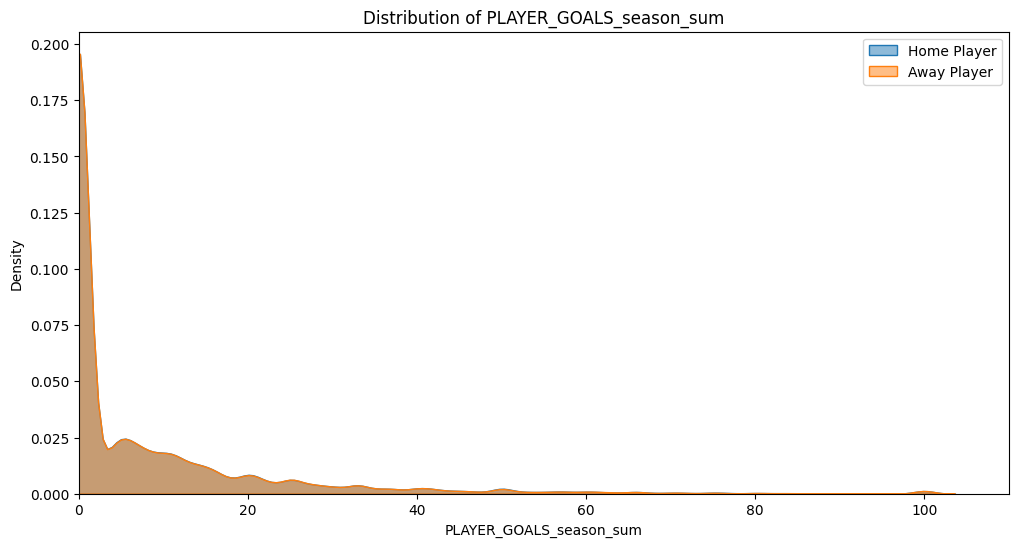

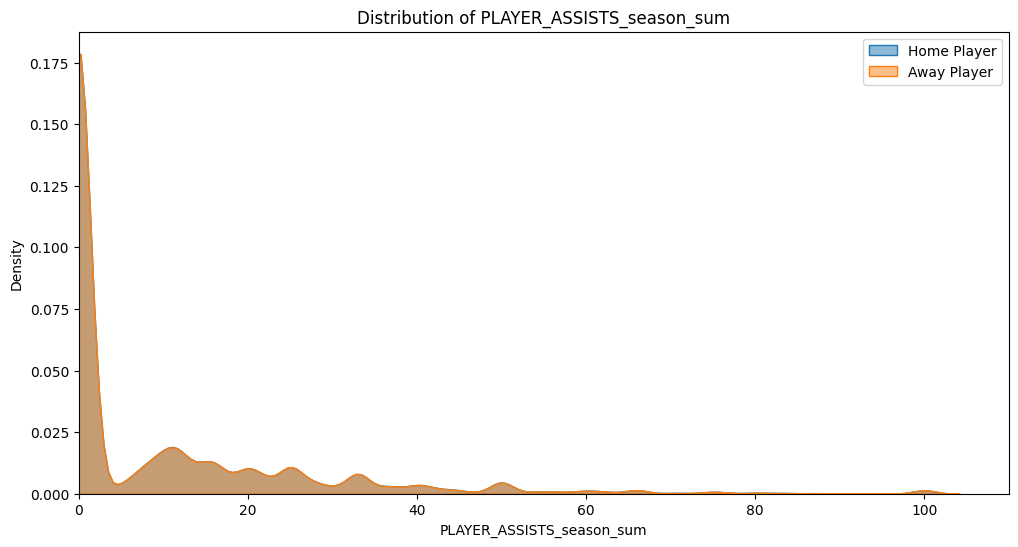

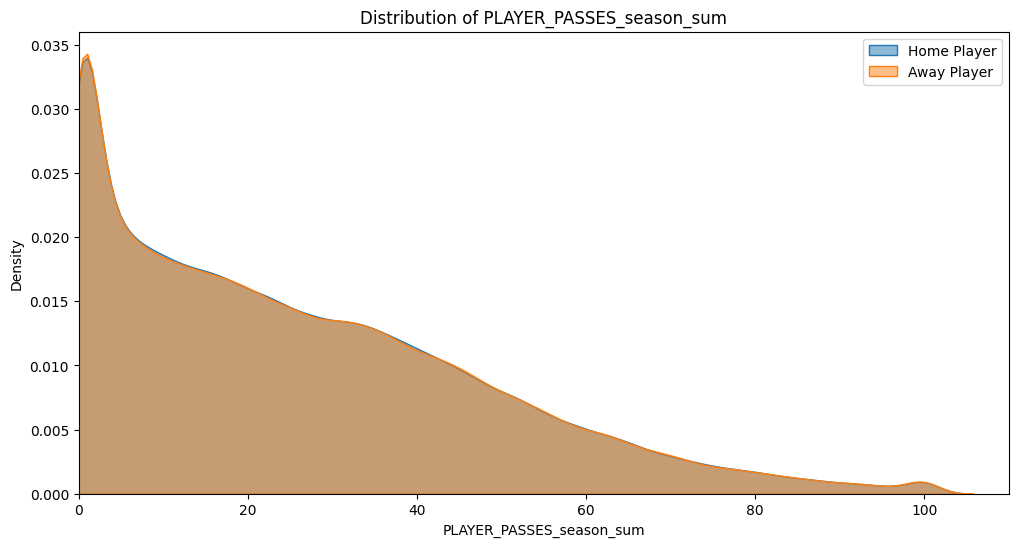

/var/folders/9w/j15v94g54sb5qs5v37wcw4wm0000gn/T/ipykernel_25815/3420469550.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/9w/j15v94g54sb5qs5v37wcw4wm0000gn/T/ipykernel_25815/3420469550.py:73: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, overall_max * 1.1)


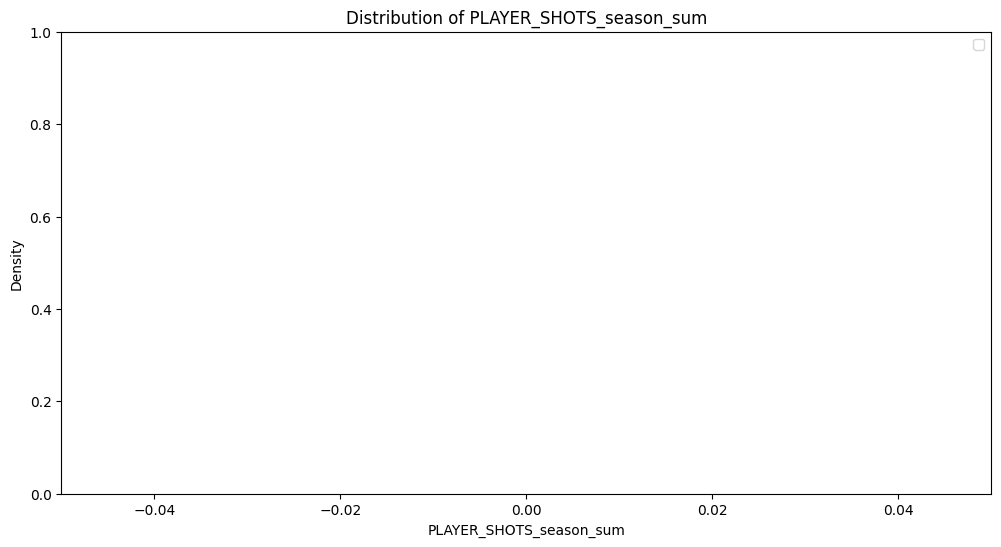

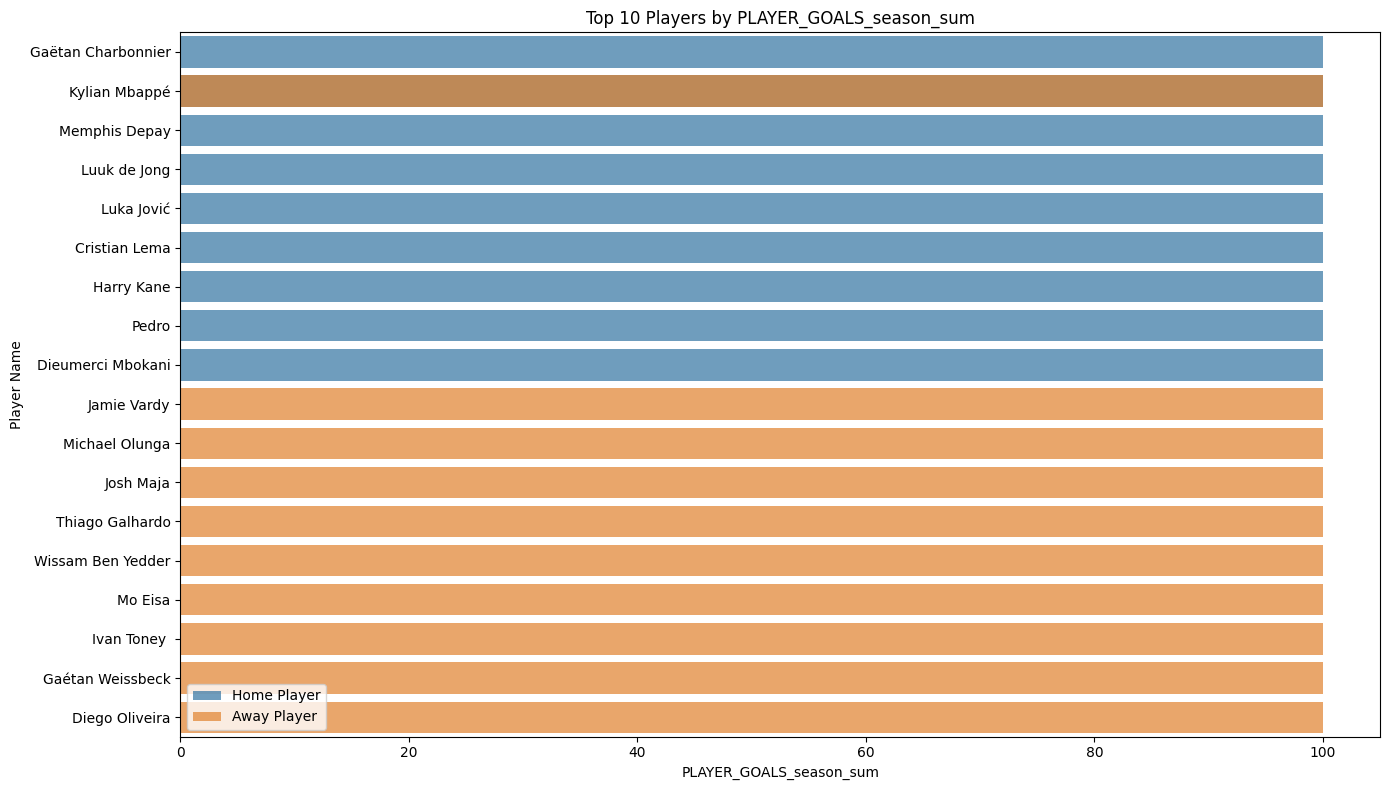

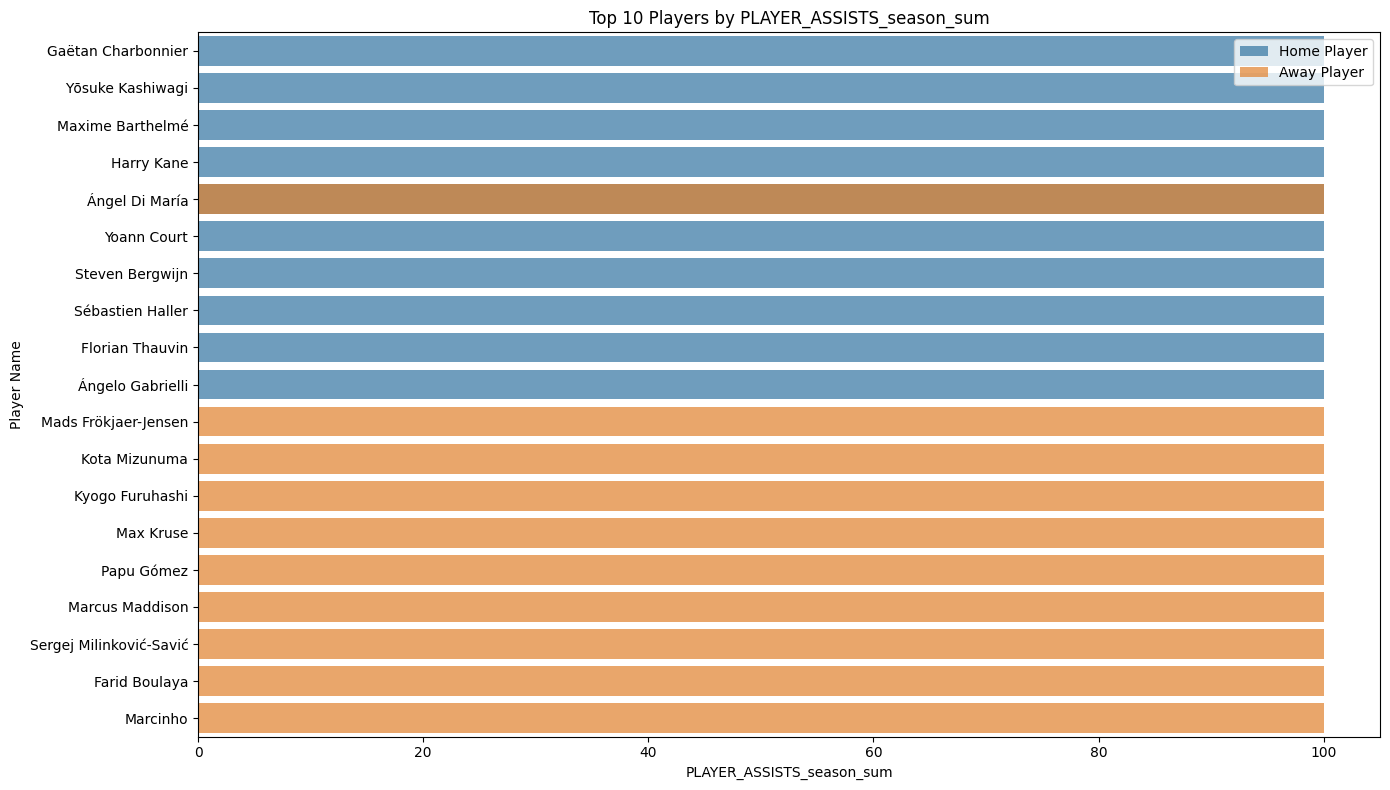

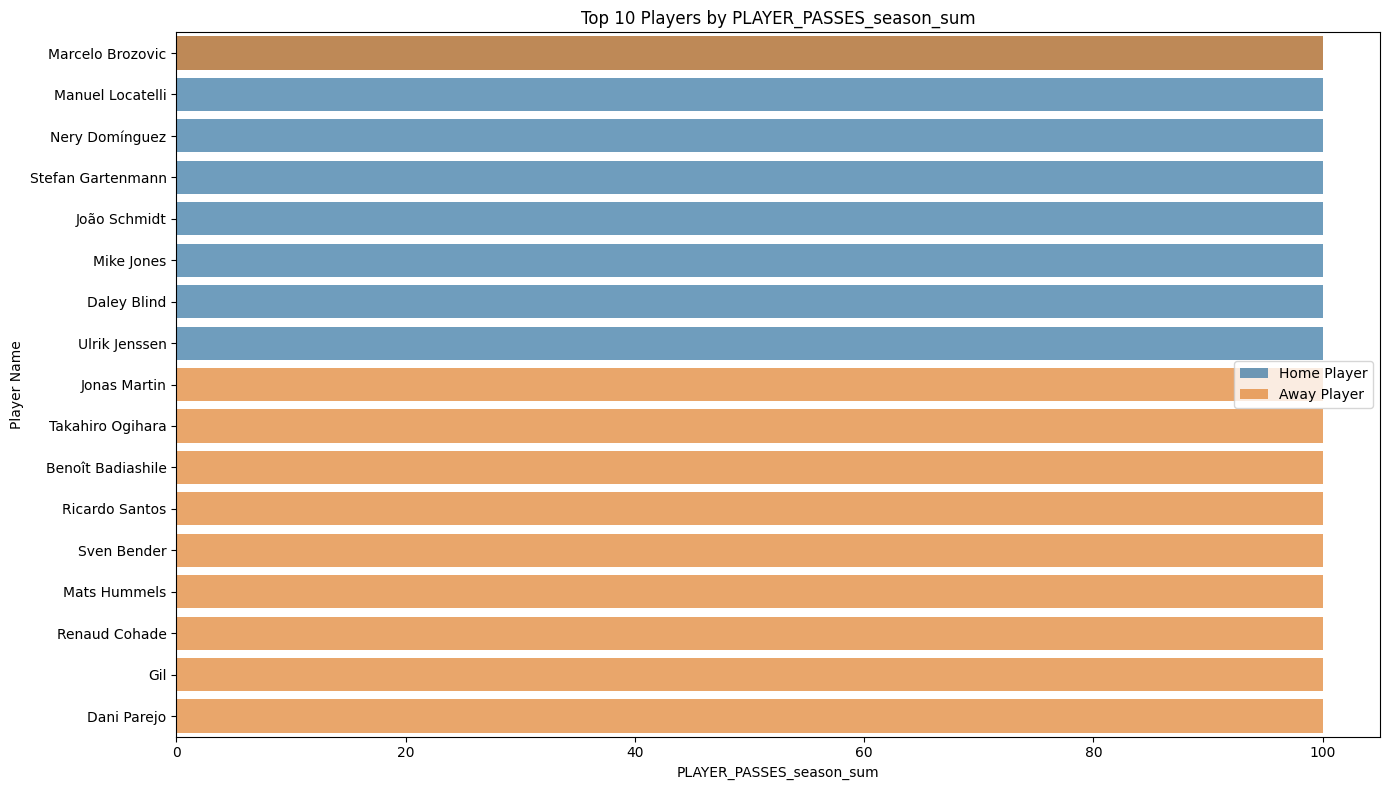

/var/folders/9w/j15v94g54sb5qs5v37wcw4wm0000gn/T/ipykernel_25815/3420469550.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


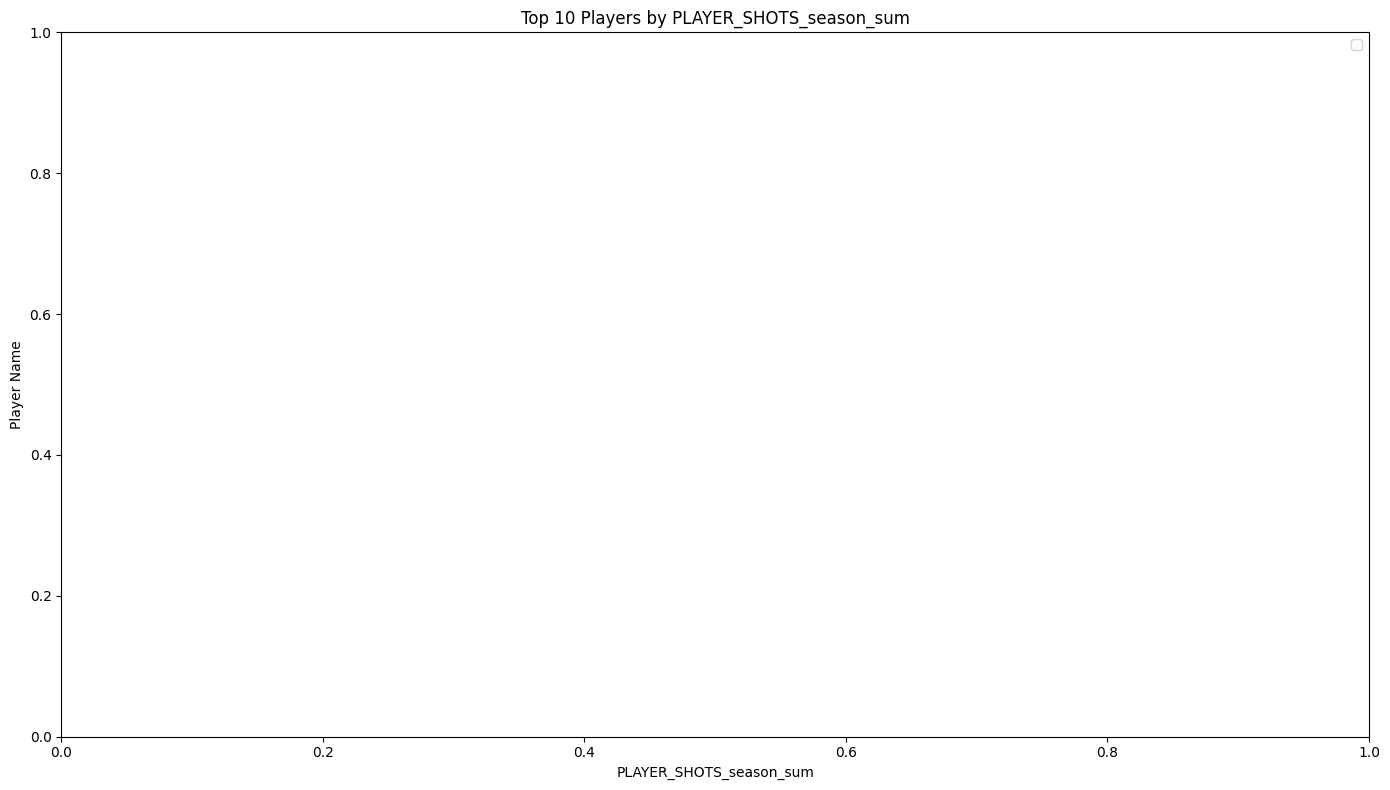

NameError: name 'train_scores' is not defined

In [17]:
%matplotlib inline

def analyze_player_dataset_structure():
    player_datasets = {
        'Home Player': train_home_player,
        'Away Player': train_away_player
    }
    
    print("Player Dataset Shapes and Missing Values:\n")
    for name, df in player_datasets.items():
        print(f"{name}: {df.shape}")
        print(f"Missing values: {df.isna().sum().sum()}\n")

def analyze_player_missing_values():
    player_datasets = {
        'Home Player': train_home_player,
        'Away Player': train_away_player
    }
    
    print("Missing Values in Player Datasets:\n")
    for name, df in player_datasets.items():
        missing = df.isna().sum()
        missing = missing[missing > 0]
        if not missing.empty:
            print(f"{name} Missing Values:")
            print(missing)
            print("\n")
        else:
            print(f"{name} has no missing values.\n")

def analyze_player_summary_statistics():
    player_datasets = {
        'Home Player': train_home_player,
        'Away Player': train_away_player
    }
    
    print("Summary Statistics for Player Datasets:\n")
    for name, df in player_datasets.items():
        print(f"{name} Summary Statistics:")
        display(df.describe())
        print("\n")

def analyze_player_metrics_distribution():
    player_datasets = {
        'Home Player': train_home_player,
        'Away Player': train_away_player
    }
    
    # Identify key player metrics; adjust column names as necessary
    key_metrics = [
        'PLAYER_GOALS_season_sum',
        'PLAYER_ASSISTS_season_sum',
        'PLAYER_PASSES_season_sum',
        'PLAYER_SHOTS_season_sum'
    ]
    
    for metric in key_metrics:
        plt.figure(figsize=(12, 6))
        for name, df in player_datasets.items():
            if metric in df.columns:
                sns.kdeplot(df[metric].dropna(), label=name, fill=True, alpha=0.5)
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('Density')
        plt.legend()
        
        # Set x-axis limit based on the metric's max value
        max_val = player_datasets['Home Player'][metric].max() if metric in player_datasets['Home Player'].columns else 0
        max_val_away = player_datasets['Away Player'][metric].max() if metric in player_datasets['Away Player'].columns else 0
        overall_max = max(max_val, max_val_away)
        
        # Add some padding to the max value
        plt.xlim(0, overall_max * 1.1)
        
        plt.show()

def analyze_player_top_performers():
    player_datasets = {
        'Home Player': train_home_player,
        'Away Player': train_away_player
    }
    
    # Identify key player metrics; adjust column names as necessary
    key_metrics = [
        'PLAYER_GOALS_season_sum',
        'PLAYER_ASSISTS_season_sum',
        'PLAYER_PASSES_season_sum',
        'PLAYER_SHOTS_season_sum'
    ]
    
    for metric in key_metrics:
        plt.figure(figsize=(14, 8))
        for name, df in player_datasets.items():
            if metric in df.columns and 'PLAYER_NAME' in df.columns:
                top_players = df.nlargest(10, metric)
                sns.barplot(x=metric, y='PLAYER_NAME', data=top_players, label=name, alpha=0.7)
        plt.title(f'Top 10 Players by {metric}')
        plt.xlabel(metric)
        plt.ylabel('Player Name')
        plt.legend()
        plt.tight_layout()
        plt.show()

def analyze_player_correlations():
    # Merge home and away player stats
    player_stats = pd.concat([train_home_player, train_away_player], axis=0)
    
    # Merge with train_scores to get target variable
    # Assuming 'ID' corresponds to match ID; adjust if different
    if 'ID' in player_stats.columns and 'ID' in train_scores.columns:
        player_stats = player_stats.merge(train_scores[['AWAY_WINS']], left_on='ID', right_index=True)
    else:
        print("ID column not found in player_stats or train_scores. Adjust the merge accordingly.")
        return
    
    # Select key metrics for correlation
    key_metrics = [
        'PLAYER_GOALS_season_sum',
        'PLAYER_ASSISTS_season_sum',
        'PLAYER_PASSES_season_sum',
        'PLAYER_SHOTS_season_sum'
    ]
    
    correlations = {}
    for metric in key_metrics:
        if metric in player_stats.columns:
            corr = player_stats[metric].corr(player_stats['AWAY_WINS'])
            correlations[metric] = corr
    
    # Plot correlations
    metrics = list(correlations.keys())
    corr_values = list(correlations.values())
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics, y=corr_values, palette='viridis')
    plt.title('Correlation between Player Metrics and Away Wins')
    plt.ylabel('Correlation Coefficient')
    plt.xlabel('Player Metrics')
    plt.ylim(-1, 1)
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.show()
    
    print("Player Metrics Correlation with Away Wins:")
    for metric, corr in correlations.items():
        print(f"{metric}: {corr:.4f}")

# Run Player EDA
print("Running Player Statistics EDA...\n")
analyze_player_dataset_structure()
analyze_player_missing_values()
analyze_player_summary_statistics()
analyze_player_metrics_distribution()
analyze_player_top_performers()
analyze_player_correlations()